Converting object detection style data (multiple instances of an object per image) into point-to-box style data (one box and object-prompt per cropped image) for surfer annotations on frames from surf-spot web-cam footage.

In [1]:
#hide
%reload_ext autoreload
%autoreload 2

In [2]:
import point_to_box.utils as utils
import point_to_box.data as data
import point_to_box.model as model
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import glob
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as opt
from PIL import Image

In [205]:
# SRC = Path('../../../surfer_det_data')
# imgs_path = SRC/'images'
# lbls_path = SRC/'annotations'

SRC = Path('../../../temp_imgs_folder')
DST = Path('../../../surfer_det_data/converted_images_v3')
ANNOS = 'single_surfer_ptb_v3.json'

In [132]:
json_data = utils.yolo_to_coco(imgs_path, lbls_path)

In [133]:
with open(imgs_path/'surfer_det_coco.json', 'w') as json_file:
    json.dump(json_data, json_file)

Create conversion dataset

In [206]:
conv_ds = data.ConversionDataset(data_path = SRC, 
                                 anno_fname = ANNOS,
                                 dst_path = DST, 
                                 crop_size = 180,
                                 crop_noise = 0.5, box_noise = 0.3,
                                 prompt_format = 'box',
                                 img_size = 224, n = 6)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Plot an image with annotations from the dataset

In [167]:
# img_id = 101
img_id = 201

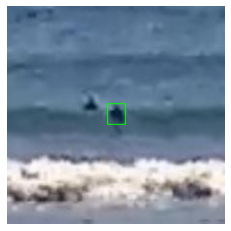

In [176]:
#hide_input
img, bboxs, prompts, cats = conv_ds.load_img(img_id)
img_w_boxes=utils.draw_rect(np.array(img), np.reshape(np.array(bboxs), (-1, 4)))
plt.imshow(img_w_boxes)
plt.axis('off')
plt.show()

Plot sample ptb data converted from above image

In [177]:
# crop objects into individual images
t = conv_ds.crop_objs(img, bboxs, prompts, cats, 
                      resize = True, img_size=224,
                      inp_crop_size = 180, crop_noise = 0.5, box_noise = 0.3)  # crop_noise = 0.05, box_noise = 0.01
imgs_crop, boxs_crop, cntrs_crop, cats_crop = t

In [178]:
len(imgs_crop)

6

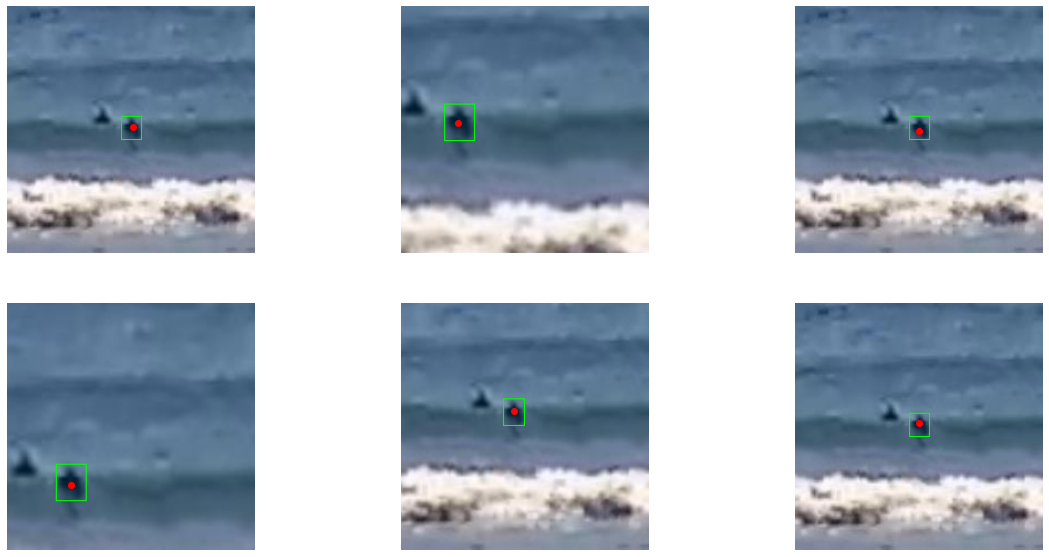

In [180]:
# plot
fig = plt.figure(figsize = (20,10))
# for i in range(1, len(imgs_crop) + 1):
for i in range(1, min(len(imgs_crop) + 1, 7)):
    crop_img_w_box = utils.draw_rect(imgs_crop[i-1], 
                                     np.array([boxs_crop[i-1]]))
    fig.add_subplot(2,3,i)
    plt.imshow(crop_img_w_box)
    plt.plot(cntrs_crop[i-1][0], cntrs_crop[i-1][1], 'ro')
    plt.axis('off')
plt.show()

In [207]:
conv_ds.convert_all(cord_format = 'corner_ofst_frac')

100%|██████████| 1644/1644 [00:23<00:00, 68.91it/s]


In [208]:
conv_ds.to_json(pct = 0.2)

Moving val images: 100%|██████████| 1974/1974 [00:00<00:00, 3412.34it/s]


In [217]:
ptbdata = data.PTBDataset(root = DST/'train',
    annos = DST/f'train/train_individual_{ANNOS}')

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [218]:
ptbloader = torch.utils.data.DataLoader(dataset = ptbdata, batch_size = 8, shuffle = True)

In [219]:
dl = iter(ptbloader)

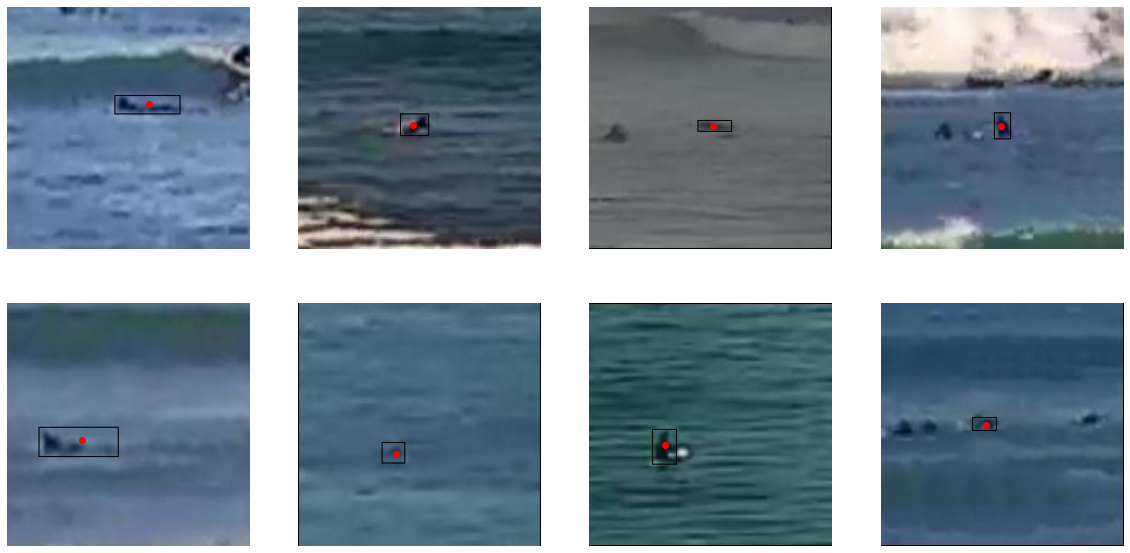

In [220]:
#hide_input
batch_imgs, batch_boxes = next(dl)
# batch_imgs, batch_boxes = batch_imgs.numpy(), batch_boxes.numpy()
fig = plt.figure(figsize = (20,10))
for i, (img, box) in enumerate(zip(batch_imgs, batch_boxes)):
    img_only = img[:3,:,:].permute(1,2,0).numpy()
    mask = img[3:,:,:].permute(1,2,0).numpy()
    ycntr, xcntr, _ = np.where(mask == mask.max())
    box = np.array([box.numpy()])
    crop_img_w_box = utils.draw_rect(img_only, box, 
                                     box_format = 'corner_ofst_frac',
#                                      box_format = 'coco',
                                     color = [(0,255,0)])
#     print(crop_img_w_box*255)
    fig.add_subplot(2,4,i+1)
    plt.imshow((crop_img_w_box*255).astype('uint8'))
    plt.plot(xcntr, ycntr, 'ro')
    plt.axis('off')
plt.show()

In [55]:
len(os.listdir('../../../surfer_det_data/converted_images_v2/val/'))

2809

In [56]:
imgs = os.listdir('../../../surfer_det_data/converted_images_v2/val/')

In [58]:
'img_2950_anno_2950_surfer_.jpg' in imgs

False

In [7]:
val_imgs = os.listdir(SRC/'converted_images_v2/val')
val_imgs = [i for i in val_imgs if i.endswith('.jpg')]
val_img_ids = [int(i.split('_')[1]) for i in val_imgs]

In [9]:
len(val_imgs)

2808

In [10]:
jsn = json.load(open(SRC/'converted_images_v2/val/val_individual_surfer_det_coco.json'))

In [11]:
jsn_img_ids = [j['image_id'] for j in jsn['annotations']]

In [12]:
len(jsn_img_ids)

2808

In [13]:
same = [i in jsn_img_ids for i in val_img_ids]

In [14]:
same[:10]

[True, True, True, True, True, True, True, True, True, True]

In [15]:
sum(same)

2808

In [56]:
SRC = Path('../../../')
imgs = 'surfer_det_data/converted_images_v2/val/'
lbls = 'yolo_labels_master'
DST = Path('temp_imgs_folder')

In [50]:
lbl_list = os.listdir(SRC/lbls)
lbl_list = [l for l in lbl_list if l.endswith('.txt')]
lbl_list = [l.strip('.txt') for l in lbl_list]

In [54]:
lbl_list[0]

'img_11901_anno_11901_surfer_'

In [64]:
imgs_list = os.listdir(SRC/imgs)
imgs_list = [i for i in imgs_list if i.endswith('.jpg')]
imgs_list = [i.strip('.jpg') for i in imgs_list]

In [67]:
init = [l in imgs_list for l in lbl_list]

In [75]:
for lbl in lbl_list:
    shutil.copy(SRC/imgs/(lbl+'.jpg'), SRC/DST/(lbl+'.jpg'))

In [84]:
imgs_fldr = os.listdir(SRC/DST)
imgs_fldr = [i.strip('.jpg') for i in imgs_fldr if i.endswith('.jpg')]

In [85]:
lbls_fldr = os.listdir(SRC/'yolo_labels_master')
lbls_fldr = [l.strip('.txt') for l in lbls_fldr if l.endswith('.txt')]

In [89]:
for f in lbls_fldr:
    if f not in imgs_fldr:
        print(f'File: {f}')